# Flower Species Classifier

## By Somya Bharti

AI algorithms will be incorporated into more and more everyday applications. For example, we might want to include an image classifier in a smart phone app. To do this, we would use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, I'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice I would train this classifier, then export it for use in our application. I'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories.

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content



### Importing the packages

In [11]:

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from PIL import Image
import json
import os
from matplotlib.ticker import FormatStrFormatter

## Load the data

Here I'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. Also, I need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. 

The pre-trained networks I'll be using are trained on the ImageNet dataset where each color channel was normalized separately. For all three sets I'll need to normalize the means and standard deviations of the images to what the network expects.
 

In [14]:
data_dir = 'flowers'
train_dir = (data_dir + '/train')
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [47]:
# Defining transforms for the training, validation, and testing sets
data_transforms = {'train_transforms': transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(30),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])]),
                   'valid_transforms': transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])]),
                   'test_transforms': transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
                  }

# Load the datasets with ImageFolder
image_datasets = {'train_data': datasets.ImageFolder(train_dir, transform=data_transforms['train_transforms']),
                   'valid_data': datasets.ImageFolder(valid_dir, transform=data_transforms['valid_transforms']),
                   'test_data': datasets.ImageFolder(valid_dir, transform=data_transforms['test_transforms'])
                  }

# Using the image datasets and the trainforms, define the dataloaders
dataloaders= {'trainloader': torch.utils.data.DataLoader(image_datasets['train_data'], batch_size=64, shuffle=True),
              'validloader': torch.utils.data.DataLoader(image_datasets['valid_data'], batch_size=32, shuffle=True),
              'testloader': torch.utils.data.DataLoader(image_datasets['test_data'], batch_size=32, shuffle=True)
             }

### Label mapping


In [21]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. 

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) 
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters



In [5]:
model = models.vgg16(pretrained=True)
model.name = "vgg16"
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\somya/.cache\torch\checkpoints\vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [22]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [23]:
# Define a new, untrainted feed-forward network as a classifier, using ReLU activations and dropout
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.5)),
                          ('fc2', nn.Linear(4096, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [24]:
#Use gpu if available else cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
            
#Criterion and optimizer
#Update weights of parameters (use momentum)
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)
#Define loss (Negative log likelihood loss)
criterion = nn.NLLLoss()

#Function for validation    
def validation(model, loader, criterion):
    loss = 0
    accuracy = 0
    
    for images, labels in iter(loader):

        #Shift to gpu
        images, labels = images.to(device), labels.to(device)
        
        #Move to next image and calculate loss 
        output = model.forward(images)
        loss += criterion(output, labels).item()

        #Take exponent of log output
        ps = torch.exp(output)
        #Compare label with predicted class
        equality = (labels.data == ps.max(dim=1)[1])
        #Correct predictions/Total predictions
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return loss, accuracy
    
#Train classifier layers using backpropogation, track loss and accuracy
epoch = 3
print_every = 5
steps = 0

for e in range(epoch):
    running_loss = 0
    for images, labels in iter(dataloaders['trainloader']):
        
        #Training mode- dropout on
        model.train()
        
        steps += 1
        
        #Shift to gpu
        images, labels = images.to(device), labels.to(device)
        
        #Reset optimizer to 0
        optimizer.zero_grad()
        #Forward and backward passes
        output = model.forward(images) 
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        #Track loss
        running_loss += loss.item()
        
        #Print loss every 50 steps
        if steps % print_every == 0:
            
            #Evaluation mode- dropout turned off
            model.eval()
            
            #Turn off gradients
            with torch.no_grad():
                valid_loss, accuracy = validation(model, dataloaders['validloader'], criterion)
                
            print("Epoch: {}/{}..".format(e+1,epoch),
                 "Training Loss: {:.3f}..".format(running_loss/print_every),
                 "Validation Loss: {:.3f}..".format(valid_loss/len(dataloaders['validloader'])),
                 "Validation Accuracy: {:.3f}%..".format(100*(accuracy/len(dataloaders['validloader']))))
        
            running_loss = 0
            
            #Training mode- dropout truned on
            model.train()

Epoch: 1/3.. Training Loss: 4.581.. Validation Loss: 4.354.. Validation Accuracy: 9.589%..
Epoch: 1/3.. Training Loss: 4.409.. Validation Loss: 4.067.. Validation Accuracy: 14.583%..
Epoch: 1/3.. Training Loss: 4.179.. Validation Loss: 3.804.. Validation Accuracy: 20.593%..
Epoch: 1/3.. Training Loss: 3.823.. Validation Loss: 3.564.. Validation Accuracy: 24.693%..
Epoch: 1/3.. Training Loss: 3.708.. Validation Loss: 3.427.. Validation Accuracy: 24.987%..
Epoch: 1/3.. Training Loss: 3.515.. Validation Loss: 3.157.. Validation Accuracy: 33.801%..
Epoch: 1/3.. Training Loss: 3.139.. Validation Loss: 2.923.. Validation Accuracy: 39.116%..
Epoch: 1/3.. Training Loss: 3.134.. Validation Loss: 2.794.. Validation Accuracy: 36.685%..
Epoch: 1/3.. Training Loss: 3.045.. Validation Loss: 2.693.. Validation Accuracy: 38.635%..
Epoch: 1/3.. Training Loss: 2.849.. Validation Loss: 2.575.. Validation Accuracy: 42.361%..
Epoch: 1/3.. Training Loss: 2.841.. Validation Loss: 2.420.. Validation Accuracy:

## Testing our network



In [25]:
# Do validation on the test set
# Do validation on the test set

#Evaluation mode- dropout turned off
model.eval()

#Turn off gradients
with torch.no_grad():
    test_loss, accuracy = validation(model, dataloaders['testloader'], criterion)
    
print("Test Loss: {:.4f}...".format(test_loss/len(dataloaders['testloader'])),
      "Test Accuracy: {:.4f}%...".format(100*(accuracy/len(dataloaders['testloader']))))


Test Loss: 0.9973... Test Accuracy: 75.9749%...


## Save the checkpoint

Now that our network is trained,I will save the model so that I can load it later for making predictions. 

In [26]:
# Save the checkpoint 
model.to('cpu')
# Dictionary checkpoint contains architecture parameters 
checkpoint = {'model': "vgg16",
              'classifier': classifier,
              'epoch': epoch,  
              'optimizer': optimizer.state_dict(), 
              'state_dict': model.state_dict(), 
              'class_to_idx': image_datasets['train_data'].class_to_idx 
             }
torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way I can come back to this project and keep working on it without having to retrain the network.

In [28]:
def load_checkpoint(filepath='checkpoint.pth'):
    checkpoint = torch.load(filepath)
    model = models.vgg16(pretrained=True);
    
    # Freeze parameters so we don't backprop through them
    for param in model.parameters(): param.requires_grad = False
    
    # Load stuff from checkpoint
    model.class_to_idx = checkpoint['class_to_idx']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])

    
    return model
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Inference for classification

Now I'll write a function to use a trained network for inference. That is, I'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. 




Firstly, I'll need to handle processing the input image such that it can be used in our network. 

## Image Preprocessing

I'll use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). 

Firstly, I'll resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then I'll need to crop out the center 224x224 portion of the image.



In [43]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    #Perform transformations, convert to tensor and normalize (easier)
    transform = transforms.Compose([transforms.Resize(256), 
                                    transforms.CenterCrop(224), 
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])])
    #Open image and apply transformation
    pil_image = Image.open(image)
    pil_image = transform(pil_image)
    
    #Convert to numpy array for return
    np_image = np.array(pil_image)    
            
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. This function should return a original image.

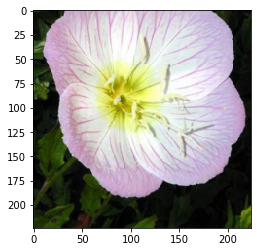

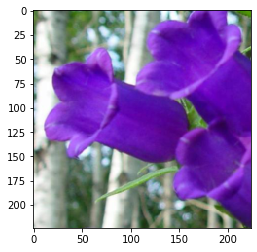

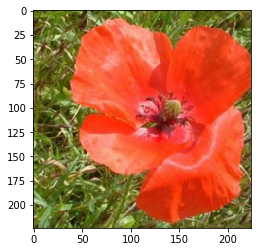

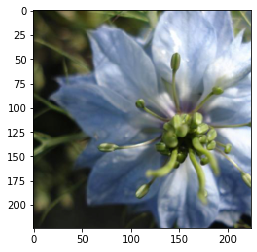

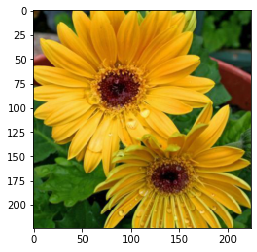

In [58]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

imshow(process_image(test_dir + '/1/image_06743.jpg'), title = "name");
imshow(process_image(test_dir + '/3/image_06641.jpg'), title = "name");
imshow(process_image(test_dir + '/26/image_06514.jpg'), title = "name");
imshow(process_image(test_dir + '/33/image_06479.jpg'), title = "name");
imshow(process_image(test_dir + '/41/image_02261.jpg'), title = "name");

## Class Prediction


Now, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. I'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor I am using [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. 


In [80]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    model = load_checkpoint(model)
    model.to(device)
    
    # For resolving the cuda and tensor issue https://discuss.pytorch.org/t/torch-cuda-floattensor-type-and-torch-floattensor/1006
    np_image = process_image(image_path) #numpy array returned
    torch_image = torch.from_numpy(np_image).to(device) #convert to cuda tensor
    torch_image = torch_image.unsqueeze_(0).float() #returns float 'cuda' tensor of single dimension (1 column)  
    
    with torch.no_grad(): 
        output = model.forward(torch_image) 
        ps = torch.exp(output) 
    
    #taking top 5 probabilities and their indices 
    probs, indices = torch.topk(ps, topk)
    
    #invert class_to_idx
    inv_class_to_idx = {index: cls for cls, index in model.class_to_idx.items()}
    
    classes = []
    for index in indices.cpu().numpy()[0]: #iterating through indices
        classes.append(inv_class_to_idx[index])
    
    return probs.cpu().numpy()[0], classes

probs, classes = predict(test_dir + '/41/image_02261.jpg', 'checkpoint.pth')

print(probs)
print(classes)

[9.9132711e-01 7.0057348e-03 9.9491642e-04 2.6726697e-04 1.5063577e-04]
['41', '66', '63', '5', '71']


## Sanity Checking

Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. 

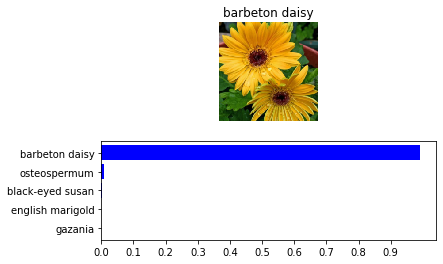

In [81]:
# Display an image along with the top 5 classes
# Display an image along with the top 5 classes
image_path = test_dir + '/41/image_02261.jpg'

probs, classes = predict(image_path, 'checkpoint.pth')

classes = [cat_to_name[c] for c in classes] #convert class integer to flower name
title = classes[0] #highest probability class
image = imshow(process_image(image_path), ax = plt.subplot(2, 1, 1)) #show image
image.axis("off") #removing axis of image
image.set_title(title) #title is highest probability of class

plt.subplot(2, 1, 2)
y_axis = np.arange(5) #top 5 prob
x_axis = np.flip(probs, 0) #flip numpy array
plt.barh(y_axis, x_axis, align='center', color='blue')
plt.yticks(y_axis, np.flip(classes, 0)) #flip classes
plt.xticks(np.arange(0,1,0.1))
plt.show()